# Seniment Analysis of Amazon Fine Food Reviews
The purpose of this notebook is to make a prediction model that predicts whether a recommendation is positive or negative.
This will be achieved by building a Term-document incidence matrix using term frequency and inverse document frequency. 

The dataset is taken from: https://www.kaggle.com/snap/amazon-fine-food-reviews

### Import libraries

In [26]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

### Load the data
The SQLITE dataset will be used and the score and recommendation summary will be extracted.

Since we only want a global sentiment of recommendations (i.e. positive or negative), we will ignore all neutral scores (equal to 3). If a score id is greater than 3 then the it will be classified as positive. Otherwise, it will be classified as negative.

In [6]:
connection = sqlite3.connect(r'C:\Users\vinhe\Code\Projects\amazon-reviews-sentiment-analysis\database.sqlite')

pd.read_sql_query("SELECT * FROM Reviews LIMIT 5", connection)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#### Extract data

In [10]:
reviews = pd.read_sql_query("""
    SELECT
        Score,
        Summary,
        HelpfulnessNumerator as VotesHelpful,
        HelpfulnessDenominator as VoteTotal
    FROM Reviews
    WHERE Score != 3""",
    connection)

In [11]:
reviews.head()

,Score,Summary,VotesHelpful,VoteTotal
0,5,Good Quality Dog Food,1,1
1,1,Not as Advertised,0,0
2,4,"""Delight"" says it all",1,1
3,2,Cough Medicine,3,3
4,5,Great taffy,0,0


### Feature Engineering
Add a Positive column which converts the numeric score into either 1 or 0.

Also, add a Usefulness column that converts number of votes into a 1 or 0.

In [14]:
reviews["Positive"] = reviews["Score"].apply(lambda score: 1 if score > 3 else 0)
reviews["Useful"] = (reviews["VotesHelpful"]/reviews["VoteTotal"]).apply(lambda n: 1 if n > 0.8 else 0)

In [15]:
reviews.head()

,Score,Summary,VotesHelpful,VoteTotal,Positive,Useful
0,5,Good Quality Dog Food,1,1,1,1
1,1,Not as Advertised,0,0,0,0
2,4,"""Delight"" says it all",1,1,1,1
3,2,Cough Medicine,3,3,0,1
4,5,Great taffy,0,0,1,0


In [18]:
reviews[reviews["Score"] == 5].head()

,Score,Summary,VotesHelpful,VoteTotal,Positive,Useful
0,5,Good Quality Dog Food,1,1,1,1
4,5,Great taffy,0,0,1,0
6,5,Great! Just as good as the expensive brands!,0,0,1,0
7,5,"Wonderful, tasty taffy",0,0,1,0
8,5,Yay Barley,1,1,1,1


In [19]:
reviews[reviews["Score"] == 1].head()

,Score,Summary,VotesHelpful,VoteTotal,Positive,Useful
1,1,Not as Advertised,0,0,0,0
12,1,My Cats Are Not Fans of the New Food,1,1,0,1
26,1,Nasty No flavor,0,1,0,0
47,1,Don't like it,0,7,0,0
57,1,stale product.,2,2,0,1


### Extract features from text data
SciKit cannot work directly with words. To workaround this, we will assign a new dimension to each word and use word counts.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import re

clean_re = re.compile('[^a-z]+')
def clean(sentence):
    sentence = sentence.lower()
    sentence = clean_re.sub(' ', sentence).strip()
    return sentence

reviews["Summary_clean"] = reviews["Summary"].apply(clean)

train, test = train_test_split(reviews, test_size=0.2)
print("%d items in the training data, %d in the test data" % (len(train), len(test)))

420651 items in the training data, 105163 in the test data


In [22]:
reviews.head()

,Score,Summary,VotesHelpful,VoteTotal,Positive,Useful,Summary_clean
0,5,Good Quality Dog Food,1,1,1,1,good quality dog food
1,1,Not as Advertised,0,0,0,0,not as advertised
2,4,"""Delight"" says it all",1,1,1,1,delight says it all
3,2,Cough Medicine,3,3,0,1,cough medicine
4,5,Great taffy,0,0,1,0,great taffy


In [25]:
count_vect = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_counts = count_vect.fit_transform(train["Summary_clean"])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = count_vect.transform(test["Summary_clean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["Positive"]
y_test = test["Positive"]

prediction = dict()

### Visualisation with WordClouds

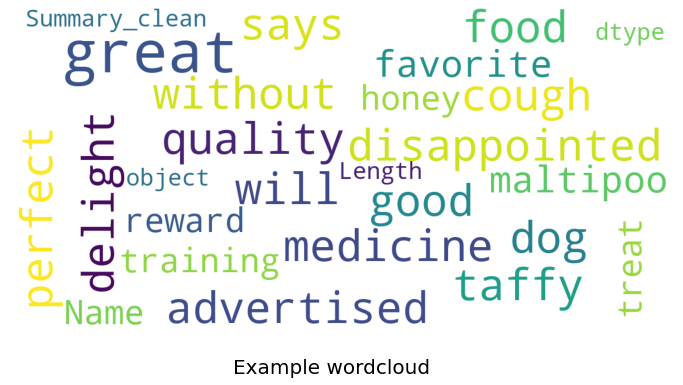

In [79]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
mpl.rcParams['font.size']=9
mpl.rcParams['savefig.dpi']=150
mpl.rcParams['figure.subplot.bottom']=.1

def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=400,
        max_font_size=35,
        scale=3,
        random_state=1,
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(12, 8))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.5)
        
    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(reviews["Summary_clean"], title = "Example wordcloud")

#### Positive & negative reviews wordclouds

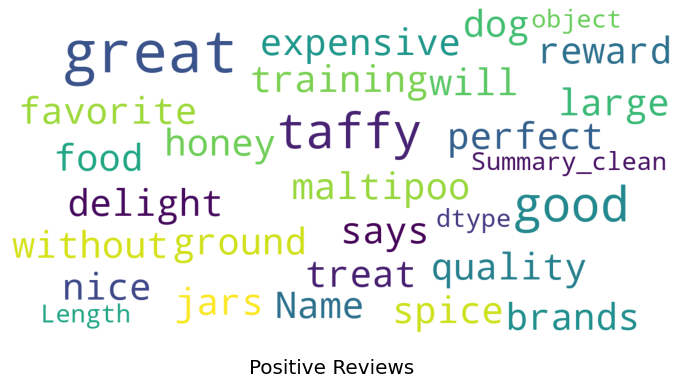

In [81]:
show_wordcloud(reviews[reviews["Positive"] == 1]["Summary_clean"], title = "Positive Reviews")

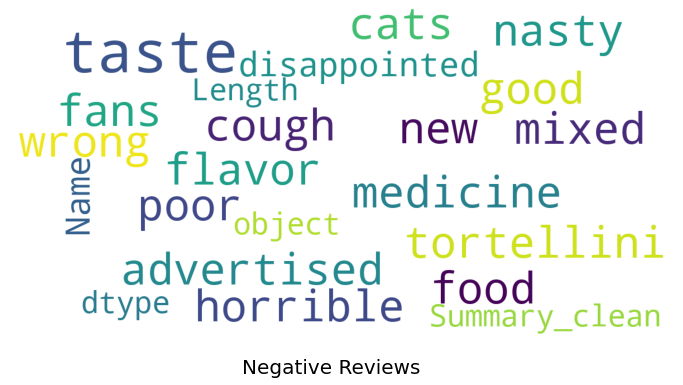

In [82]:
show_wordcloud(reviews[reviews["Positive"] == 0]["Summary_clean"], title = "Negative Reviews")

## Apply ML models
### Multinomial Naive Bayes Classifier
Naive Bayes is a classification algorithm of Machine Learning based on Bayes theorem which gives the likelihood of occurrence of the event. Naive Bayes classifier is a probabilistic classifier which means that given an input, it predicts the probability of the input being classified for all the classes. It is also called conditional probability.

Multinomial Naive Bayes Classifier is a widely used classifier for document classification which keeps the count of frequent words present in the documents.

In [83]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

### Bernouli Naive Bayes Learning Method
Bernoulli Naive Bayes is a variant of Naive Bayes. Bernoulli Naive Bayes is usedfor discrete data, where features are only in binary form.

In [85]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

### Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

C:\Users\vinhe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Results
To compare the ML algorithms a ROC (Receiver Operating Characteristic) curve will be created. The curve with the highest AUC (Area Under The Curve) value will be the best performing algorithm.

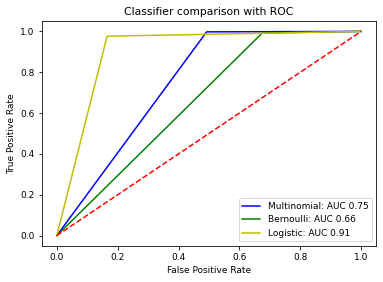

In [110]:
cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifier comparison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

The ROC curve shows that the Logistic Regression Classifier provided the best results. Although the AUC value can be improved further. We shall focus on using logistic regression for the remainder of this notebook.

### Evaluation
Create an accuracy, recall, and confusion matrix of the model.

In [113]:
print(metrics.classification_report(y_test, prediction['Logistic'],
                                   target_names = ["1", "0"]))

              precision    recall  f1-score   support

           1       0.87      0.83      0.85     16310
           0       0.97      0.98      0.97     88853

    accuracy                           0.95    105163
   macro avg       0.92      0.91      0.91    105163
weighted avg       0.95      0.95      0.95    105163



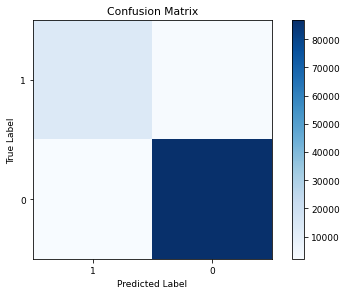

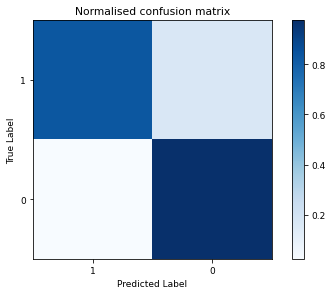

In [115]:
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues, labels=["1", "0"]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
# Compute confusion matrix
cm = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalised confusion matrix')
plt.show()

Investigate what the most positive and negative words are by looking at the coefficients:

In [116]:
words = count_vect.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(words, logreg_result.coef_[0])),
    columns = ['feature', 'coef'])

feature_coefs.sort_values(by='coef')

,feature,coef
966563,worst,-78.923222
982805,yuck,-57.627935
569261,nasty,-57.441411
597293,not too good,-56.190446
61285,awful,-50.035818
...,...,...
274627,fantastic,54.097288
80994,best,58.686354
211879,delicious,60.547819
588541,not bitter,63.857233


### Test fake reviews

In [134]:
def test_sample(model, sample):
    sample_counts = count_vect.transform([sample])
    sample_tfidf = tfidf_transformer.transform(sample_counts)
    result = model.predict(sample_tfidf)[0]
    prob = model.predict_proba(sample_tfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result, prob[0], prob[1]))
    
test_sample(logreg, "The food was yummy, it smelled amazing and the taste was incredible.")
test_sample(logreg, "The food was disgusting and it made me gag.")
test_sample(logreg, "The food was ok, I've had better, the taste was nice.")

Sample estimated as 1: negative prob 0.000003, positive prob 0.999997
Sample estimated as 0: negative prob 0.999999, positive prob 0.000001
Sample estimated as 0: negative prob 0.509706, positive prob 0.490294


### Visualise words associated the usefulness of products

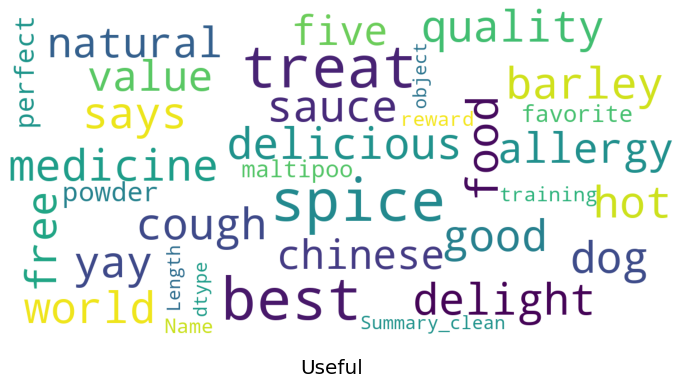

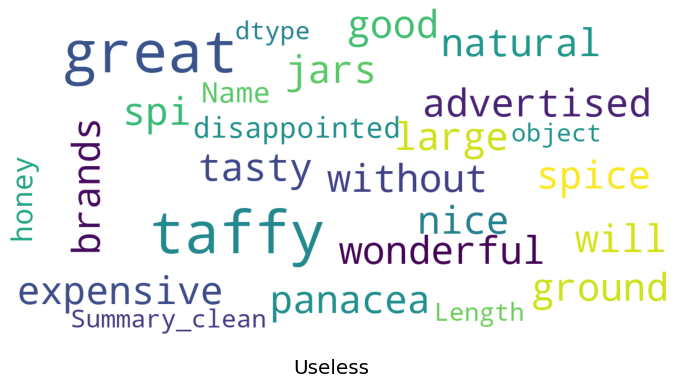

In [137]:
show_wordcloud(reviews[reviews["Useful"] == 1]["Summary_clean"], title="Useful")
show_wordcloud(reviews[reviews["Useful"] == 0]["Summary_clean"], title="Useless")

The results for the "Useless" wordcloud has a mixture of positive and negative words. Let's limit the dataset to entries with at least 10 votes.

In [147]:
reviews_min_ten_votes = reviews[reviews["VoteTotal"] >= 10]
reviews_min_ten_votes.head()

,Score,Summary,VotesHelpful,VoteTotal,Positive,Useful,Summary_clean
32,4,Best of the Instant Oatmeals,19,19,1,1,best of the instant oatmeals
33,4,Good Instant,13,13,1,1,good instant
75,5,Forget Molecular Gastronomy - this stuff rocke...,15,15,1,1,forget molecular gastronomy this stuff rockes ...
145,5,tastes very fresh,17,19,1,1,tastes very fresh
195,1,CHANGED FORMULA MAKES CATS SICK!!!!,3,10,0,0,changed formula makes cats sick


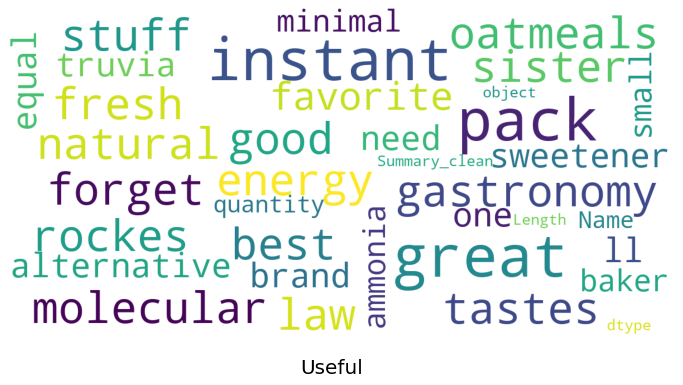

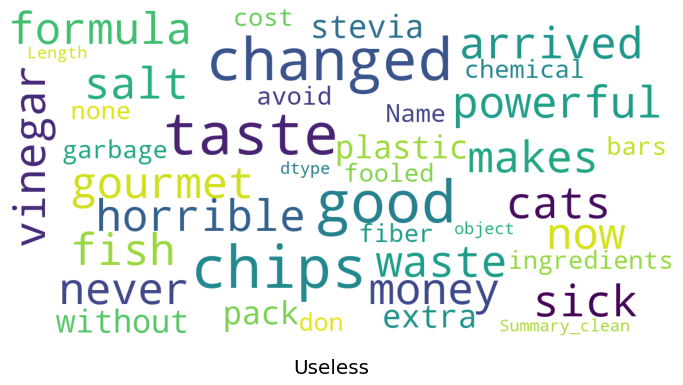

In [148]:
show_wordcloud(reviews_min_ten_votes[reviews_min_ten_votes["Useful"] == 1]["Summary_clean"], title="Useful")
show_wordcloud(reviews_min_ten_votes[reviews_min_ten_votes["Useful"] == 0]["Summary_clean"], title="Useless")

This has seems to improve the performance. Next, let's build a model.

In [154]:
from sklearn.pipeline import Pipeline

train_usefulness, test_usefulness = train_test_split(reviews_min_ten_votes, test_size=0.2)

usefulness_pipe = Pipeline([
    ('vect', CountVectorizer(min_df=1, ngram_range=(1, 4))),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='lbfgs', max_iter=10000))
])

usefulness_result = usefulness_pipe.fit(train_usefulness["Summary_clean"], train_usefulness["Useful"])

prediction['Logistic_Usefulness'] = usefulness_pipe.predict(test_usefulness["Summary_clean"])

print(metrics.classification_report(test_usefulness["Useful"], prediction['Logistic_Usefulness']))

              precision    recall  f1-score   support

           0       0.80      0.62      0.70      1641
           1       0.81      0.91      0.86      2972

    accuracy                           0.81      4613
   macro avg       0.81      0.77      0.78      4613
weighted avg       0.81      0.81      0.80      4613



Let's see which reviews were most helpful and least helpful according to the model:

In [156]:
usefulness_scores = [a[0] for a in usefulness_pipe.predict_proba(train_usefulness["Summary"])]
usefulness_scores = zip(usefulness_scores, train_usefulness["Summary"], train_usefulness["VotesHelpful"],
                       train_usefulness["VoteTotal"])
usefulness_scores = sorted(usefulness_scores, key=lambda t: t[0], reverse=True)

pd.DataFrame(usefulness_scores)

,0,1,2,3
0,0.985281,Not 80's,86,88
1,0.940464,The worst!!,6,16
2,0.940464,The worst !!!,1,16
3,0.940464,The worst!!,6,16
4,0.940464,The Worst,1,11
...,...,...,...,...
18447,0.008024,The Best,13,13
18448,0.008024,The Best!,12,12
18449,0.008024,The best,11,11
18450,0.008024,The Best!,12,13


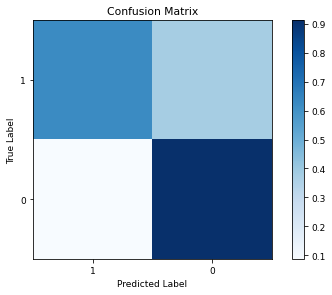

In [159]:
cm = confusion_matrix(test_usefulness["Useful"], prediction["Logistic_Usefulness"])
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm_normalised, labels=["1", "0"])

### More complex pipeline

In [166]:
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# Useful to select only certain dataset features for putting through a pipeline
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, data_dict):
        return data_dict[self.key]
    
train_usefulness2, test_usefulness2 = train_test_split(reviews_min_ten_votes, test_size=0.2)

usefulness_pipe2 = Pipeline([
   ('union', FeatureUnion(
       transformer_list = [
           ('summary', Pipeline([
               ('textsel', ItemSelector(key='Summary_clean')),
               ('vect', CountVectorizer(min_df = 1, ngram_range = (1, 4))),
               ('tfidf', TfidfTransformer())])),
          ('score', ItemSelector(key=['Score']))
       ],
       transformer_weights = {
           'summary': 0.2,
           'score': 0.8
       }
   )),
   ('model', LogisticRegression(solver='lbfgs', max_iter=10000, C=1e5))
])

usefulness_result2 = usefulness_pipe2.fit(train_usefulness2, train_usefulness2["Useful"])
prediction["Logistic_Usefulness2"] = usefulness_pipe2.predict(test_usefulness2)
print(metrics.classification_report(test_usefulness2["Useful"], prediction["Logistic_Usefulness2"]))

              precision    recall  f1-score   support

           0       0.81      0.69      0.74      1677
           1       0.83      0.91      0.87      2936

    accuracy                           0.83      4613
   macro avg       0.82      0.80      0.80      4613
weighted avg       0.82      0.83      0.82      4613



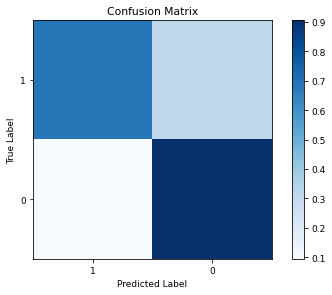

In [169]:
cm = confusion_matrix(test_usefulness2["Useful"], prediction['Logistic_Usefulness2'])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm_normalized, labels=["1", "0"])

In [170]:
len(usefulness_result2.named_steps['model'].coef_[0])

86848

Look at most positive and negative words:

In [172]:
usefulness_summary_pipe = next(tr[1] for tr in usefulness_result2.named_steps["union"].transformer_list if tr[0]=='summary')
usefulness_words = usefulness_summary_pipe.named_steps['vect'].get_feature_names()
usefulness_features = usefulness_words + ["Score"]
usefulness_feature_coefs = pd.DataFrame(
    data = list(zip(usefulness_features, usefulness_result2.named_steps['model'].coef_[0])),
    columns = ['feature', 'coef'])
usefulness_feature_coefs.sort_values(by='coef')

,feature,coef
1798,amazingly good coffee,-101.500564
29099,fun nostalgia,-92.398742
47108,mmmm mmm,-89.053590
49557,new review,-88.454635
71864,the best,-84.425888
...,...,...
9577,blk water,85.251915
7590,best,87.501484
2301,and,88.971309
78019,total ripoff,89.637288


In [174]:
print("The coefficient of the score variable: ")
usefulness_feature_coefs[usefulness_feature_coefs["feature"] == 'Score']

The coefficient of the score variable: 


,feature,coef
86847,Score,1.174877
